In [5]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

### 1 hour frequency long-short strategy

# Bactest Framework

In [6]:
class Backtest():
    def __init__(self):
        self.data_path = './1hour_data/'

        self.close = pd.read_parquet(os.path.join(self.data_path, 'close.parquet'))
        self.volume = pd.read_parquet(os.path.join(self.data_path, 'volume.parquet'))
        self.valid = self.volume > 0

        self.min_return = self.close.pct_change() * self.valid

    def _get_signal_weight(self, signal, type):
        if type == 'TOP/BOTTOM':
            K = int(signal.shape[1]/10)
            top_mask = signal.rank(axis=1, ascending=False, method='first') <= K
            bottom_mask = signal.rank(axis=1, ascending=True, method='first') <= K
            weight = pd.DataFrame(columns=signal.columns, index=signal.index, data = 0)
            weight.mask(top_mask, 1, inplace=True)
            weight.mask(bottom_mask, -1, inplace=True)
            weight = weight/K
            self.booksize = 2
            
        elif type == 'LONG/SHORT':
            weight = signal.copy()
            weight = weight.sub(weight.mean(axis = 1) , axis = 0)
            weight = weight.div(weight.abs().sum(axis=1) /2 ,axis = 0)
            self.booksize = 2

        self.weight = weight

    def _get_pnl(self):
        pnl = pd.DataFrame()
        temp_min_return = self.min_return.loc[self.weight.index]
        pnl['pnl_before_cost'] = (self.weight * temp_min_return).sum(axis=1)/self.booksize

        pnl['turnover_rate'] = self.weight.diff().abs().sum(axis=1) / self.booksize
        trade_fee = 0.001
        pnl['trade_fee'] = trade_fee * pnl['turnover_rate']
        pnl['pnl_after_cost'] = pnl['pnl_before_cost'] - pnl['trade_fee'] 

        self.pnl = pnl

    def _cal_performance_given_pnl(self, pnl):
        # number of trading times each year
        N = int(365 * 24)
        return pd.Series({
        'Sharpe' : pnl['pnl_after_cost'].mean() / pnl['pnl_after_cost'].std() * np.sqrt(N),
        'Return' : pnl['pnl_after_cost'].mean() * N,
        'WinRate' : (pnl['pnl_after_cost']>0).sum()/ (pnl.shape[0])
        })

    def _cal_performance(self):
        # number of trading times each year
        N = int(365 * 24 )

        # analyze for each year
        performance_matrix = self.pnl.groupby(self.pnl.index.year).apply(self._cal_performance_given_pnl)
        performance_matrix['Annual Turnover'] = self.pnl['turnover_rate'].groupby(self.weight.index.year).sum()
        performance_matrix['Daily Turnover'] = self.pnl['turnover_rate'].groupby(self.weight.index.year).mean() * (24)

        # analyze for whole period
        total_performance = self._cal_performance_given_pnl(self.pnl)
        total_performance['Annual Turnover'] = self.pnl['turnover_rate'].mean() * N
        total_performance['Daily Turnover'] = self.pnl['turnover_rate'].mean() *(24)
        total_performance.name = 'total'
     
        self.performance = pd.concat([performance_matrix,pd.DataFrame(total_performance).T],axis = 0)
        

    def backtest(self, signal, type, start_date = '2019-01-01', end_date = '2022-12-31'):
        signal = signal.astype(float).copy()
        signal.index = pd.to_datetime(signal.index.astype(str))
        signal.sort_index(inplace=True)
        signal = signal[(signal.index >= pd.Timestamp(start_date)) & (signal.index <= pd.Timestamp(end_date))]

        #generate portfolio weight
        self._get_signal_weight(signal, type)

        #generate historical pnl
        self._get_pnl()

        #compute historical performance
        self._cal_performance()

Backtest1 = Backtest()  



# Signals

#### Mean Reversion

In [7]:
# Remember to shift the data to prevent forward-looking bias
close = pd.read_parquet('/home/ckuang/crypto/1hour_data/close.parquet').shift(1)
price_return = close.pct_change()

Backtest1.backtest(signal=-price_return,type="LONG/SHORT")
Backtest1.performance

,Sharpe,Return,WinRate,Annual Turnover,Daily Turnover
2019,9.739767,12.693621,0.430365,13904.393731,38.094229
2020,10.742112,12.505150,0.468693,13730.891509,37.516097
2021,8.366409,8.385899,0.528767,13287.107577,36.403034
2022,-2.464430,-2.416510,0.402083,13125.121968,36.053900
total,6.952148,7.801969,0.457521,13511.493095,37.017789


The signal frequency is 1hour, which means we could change our position in each of the 1hour interval. The backtest function assumes that we could either long or short any position at the price of next close. However, we should keep in mind that we might not be able to trade all of our positions at the next "close" because the large amount of trading activities would cause price impact to the asset, which will lead to the price movement to the unfavored direction. Without considering the price impact, this backtest statistics is just a distortion which could never be realized.

To reduce the distortion, we could put a limit to the turnover ratio of our signal. In this case, though we still assume to trade at the next close, but we trade with much less amount. Hopefully, this will lead to less price impact and less distortion in our backtest. 

Let's keep our daily turnover to be something around 2, which means the holding period is around 1 day. (The maximum for each 1 hour period is 200%)

In [8]:
# Remember to shift the data to prevent forward-looking bias
close = pd.read_parquet('/home/ckuang/crypto/1hour_data/close.parquet').shift(1)
price_return = close.pct_change()
signal = -price_return.rolling(24*18).mean()

Backtest1.backtest(signal=signal,type="LONG/SHORT")
display(Backtest1.performance)

signal.to_parquet('./signal/reversion1.parquet')

,Sharpe,Return,WinRate,Annual Turnover,Daily Turnover
2019,7.167846,5.465086,0.507763,671.519911,1.839781
2020,3.581880,2.717270,0.528347,686.610561,1.875985
2021,1.392657,0.929202,0.531963,725.328734,1.987202
2022,0.979435,0.609845,0.524780,728.900291,2.002244
total,3.446148,2.431742,0.523216,703.069809,1.926219


Try 3 hour return instead of 1 hour return

In [9]:
close = pd.read_parquet('/home/ckuang/crypto/1hour_data/close.parquet').shift(1)
price_return = close.pct_change(periods = 3)
signal = -price_return.rolling(24*6).mean()
Backtest1.backtest(signal=(signal),type="LONG/SHORT")
display(Backtest1.performance)

signal.to_parquet('./signal/reversion2.parquet')

,Sharpe,Return,WinRate,Annual Turnover,Daily Turnover
2019,10.439182,9.186385,0.535502,777.337522,2.129692
2020,6.074104,5.214197,0.531079,760.975367,2.079168
2021,0.622395,0.501847,0.519292,718.431060,1.968304
2022,1.504623,0.829542,0.523864,728.421082,2.000928
total,5.006573,3.935907,0.527439,746.269960,2.044575


Try 6 hour return instead of 1 hour return

In [10]:
close = pd.read_parquet('/home/ckuang/crypto/1hour_data/close.parquet').shift(1)
price_return = close.pct_change(periods = 6)
signal = -price_return.rolling(24*3).mean()
Backtest1.backtest(signal=(signal),type="LONG/SHORT")
display(Backtest1.performance)

signal.to_parquet('./signal/reversion3.parquet')

,Sharpe,Return,WinRate,Annual Turnover,Daily Turnover
2019,10.759013,10.452636,0.532991,787.810453,2.158385
2020,6.619033,5.823608,0.533015,743.943118,2.032631
2021,0.553387,0.473856,0.529452,696.300531,1.907673
2022,2.407925,1.177486,0.520774,695.477740,1.910434
total,5.460121,4.484984,0.529066,730.862103,2.002362


Try 12 hour & 24 hour return

In [11]:
close = pd.read_parquet('/home/ckuang/crypto/1hour_data/close.parquet').shift(1)
price_return = close.pct_change(periods = 12)
signal = -price_return.rolling(35).mean()
Backtest1.backtest(signal=(signal),type="LONG/SHORT")
display(Backtest1.performance)

signal.to_parquet('./signal/reversion4.parquet')

,Sharpe,Return,WinRate,Annual Turnover,Daily Turnover
2019,9.443178,9.772034,0.532534,795.314446,2.178944
2020,6.741851,6.048379,0.528347,760.479670,2.077813
2021,0.303686,0.264316,0.521233,710.395626,1.946289
2022,3.159598,1.600998,0.518828,725.611160,1.993209
total,5.198297,4.424397,0.525242,747.928880,2.049120


In [12]:
close = pd.read_parquet('/home/ckuang/crypto/1hour_data/close.parquet').shift(1)
price_return = close.pct_change(periods = 24)
signal = -price_return.rolling(20).mean()
Backtest1.backtest(signal=(signal),type="LONG/SHORT")
display(Backtest1.performance)

signal.to_parquet('./signal/reversion5.parquet')

,Sharpe,Return,WinRate,Annual Turnover,Daily Turnover
2019,8.329650,8.297992,0.522260,794.135815,2.175715
2020,6.009196,5.528877,0.525956,770.655354,2.105616
2021,0.018641,0.016256,0.520434,719.199232,1.970409
2022,2.725768,1.368624,0.517340,734.362815,2.017249
total,4.502450,3.805717,0.521503,754.566770,2.067306


We could see that when we use negative 1 hour return as our signal, we need to apply MA(24*18) to reduce the turnover ratio which is equivalent to previous 18 days of information, whereas if we use negative 3 hour return as our signal, the MA(24*6) uses previous 6 days of information. The 'best' seems to be 6 hour return with 3 days of information. It seems that the information decays really fast, so instead of MA which is equal weight average, I guess it might be better to use some other time weighted average like EMA.

Moreover, we could see that the performance is not stable among different years. We might want to apply some techniques such as winsorization or neutralization to reduce the risk.


In [13]:
def winsorize(signal, max_ratio = 0.05):
    mask = signal.abs() > (max_ratio * signal.abs().sum(axis = 1)).values[:, None]
    winsorized_signal = signal.copy()
    winsorized_signal[mask] = (max_ratio * signal.abs().sum(axis = 1)).values[:, None]* np.sign(signal[mask])
    return winsorized_signal

# winsorize version of -MA(6hour return, 24*3)
close = pd.read_parquet('/home/ckuang/crypto/1hour_data/close.parquet').shift(1)
price_return = close.pct_change(periods = 6)
signal = -price_return.rolling(24*3).mean()
Backtest1.backtest(signal=winsorize(signal),type="LONG/SHORT")
display(Backtest1.performance)

signal.to_parquet('./signal/reversion6.parquet')

,Sharpe,Return,WinRate,Annual Turnover,Daily Turnover
2019,12.855311,7.404009,0.535046,797.547917,2.185063
2020,8.359565,4.592850,0.523452,762.040394,2.082078
2021,1.561459,0.767292,0.516096,725.851894,1.988635
2022,2.014968,0.699328,0.511846,719.821828,1.977306
total,6.738582,3.368461,0.521618,751.294067,2.058340


In [14]:
import bottleneck as bn
import warnings

# The pandas's version of EMA: pf.ewm.mean() by default uses all the information before the current point,
# instead of restricting the current window to only include the previous K days of data. So I write my own version

# Utility function for rolling window
def move_func(func, a, window, min_count=None, axis=-1, **kwargs):
    "Generic moving window function implemented with a python loop."
    a = np.array(a, copy=False)
    if min_count is None:
        mc = window
    else:
        mc = min_count
        if mc > window:
            msg = "min_count (%d) cannot be greater than window (%d)"
            raise ValueError(msg % (mc, window))
        elif mc <= 0:
            raise ValueError("`min_count` must be greater than zero.")
    if a.ndim == 0:
        raise ValueError("moving window functions require ndim > 0")
    if axis is None:
        raise ValueError("An `axis` value of None is not supported.")
    if window < 1:
        raise ValueError("`window` must be at least 1.")
    if window > a.shape[axis]:
        raise ValueError("`window` is too long.")
    if issubclass(a.dtype.type, np.inexact):
        y = np.empty_like(a)
    else:
        y = np.empty(a.shape)
    idx1 = [slice(None)] * a.ndim
    idx2 = list(idx1)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for i in range(a.shape[axis]):
            win = min(window, i + 1)
            idx1[axis] = slice(i + 1 - win, i + 1)
            idx2[axis] = i
            y[tuple(idx2)] = func(a[tuple(idx1)], axis=axis, **kwargs)
    idx = _mask(a, window, mc, axis)
    y[idx] = np.nan
    return y

def _mask(a, window, min_count, axis):
    n = (a == a).cumsum(axis)
    idx1 = [slice(None)] * a.ndim
    idx2 = [slice(None)] * a.ndim
    idx3 = [slice(None)] * a.ndim
    idx1[axis] = slice(window, None)
    idx2[axis] = slice(None, -window)
    idx3[axis] = slice(None, window)
    idx1 = tuple(idx1)
    idx2 = tuple(idx2)
    idx3 = tuple(idx3)
    nidx1 = n[idx1]
    nidx1 = nidx1 - n[idx2]
    idx = np.empty(a.shape, dtype=np.bool_)
    idx[idx1] = nidx1 < min_count
    idx[idx3] = n[idx3] < min_count
    return idx

# Exponential moving average
def EMA(X, axis, adjust_nan = True):
    X[np.isinf(X)] = np.nan
    n = X.shape[0]
    a = 2.0/(n+1)
    weight = np.array([1.0] + [(1-a) **i for i in range(1,n)]).reshape(-1,1)[::-1]
    weight = np.tile(weight, X.shape[1])

    if adjust_nan:
        weight[np.isnan(X)] = np.nan
        mask = np.sum(~np.isnan(weight),axis = axis) == 0

        weight = weight / np.nansum(weight,axis = axis)
        ema = np.nansum(weight * X ,axis = axis)
        ema[mask] = np.nan
    else:
        weight = weight / np.nansum(weight, axis = axis)
        ema = np.sum(weight * X , axis = axis)
        ema[np.isinf(ema)] = np.nan
        
    return ema


close = pd.read_parquet('/home/ckuang/crypto/1hour_data/close.parquet').shift(1)
price_return = close.pct_change(periods = 6)
signal_ema = -price_return.copy()
signal_ema[:] = move_func(EMA, signal_ema, window = 24*6, min_count=1, axis = 0)

Backtest1.backtest(signal=winsorize(signal_ema),type="LONG/SHORT")
display(Backtest1.performance)

signal.to_parquet('./signal/reversion7.parquet')


,Sharpe,Return,WinRate,Annual Turnover,Daily Turnover
2019,17.396286,9.966930,0.567237,747.116397,2.046894
2020,11.316797,6.269781,0.537341,704.432819,1.924680
2021,3.085553,1.567961,0.521804,686.152799,1.879871
2022,3.744810,1.348938,0.520774,689.482844,1.893967
total,9.445473,4.791675,0.536800,706.776044,1.936373


Let's try the signal using the return of VWAP to see if larger trading volume could amplify the reversion effect.

In [15]:
def weighted_average(X, weight, window_size):
    product = X * weight
    rolling_product_sum = product.rolling(window = window_size, min_periods = window_size, axis = 0).sum()
    rolling_weight_sum = weight.rolling(window = window_size, min_periods = window_size, axis = 0).sum()
    return (rolling_product_sum / rolling_weight_sum)


close = pd.read_parquet('/home/ckuang/crypto/1hour_data/close.parquet').shift(1)
volume = pd.read_parquet('/home/ckuang/crypto/1hour_data/volume.parquet').shift(1)

# 12 hours VWAP
vwap = weighted_average(close, volume, 12)
price_return = vwap.pct_change(periods = 6)
signal = -price_return.rolling(24*2).mean()

Backtest1.backtest(signal=winsorize(signal),type="LONG/SHORT")
display(Backtest1.performance)

signal.to_parquet('./signal/reversion8.parquet')

,Sharpe,Return,WinRate,Annual Turnover,Daily Turnover
2019,9.712099,5.595608,0.517352,772.417356,2.116212
2020,5.825418,3.091565,0.510132,748.799668,2.045901
2021,-0.221615,-0.106539,0.503995,681.005534,1.865769
2022,0.814044,0.285632,0.498340,698.342003,1.918302
total,4.503592,2.218433,0.507463,725.120446,1.986631


The performance is worse than the original one. It could be the case that sometimes extreme trading volume could cause a price momentum, which leads to our drawdown. Since the accuracy of volume data is questionable, I will not do further analysis using the volume data.


Let's integrate the cross-sectional information in our signal by computing the cross-sectional Z-score of price return.

In [16]:
def ts_Zscore(M):
    warnings.simplefilter("ignore", category=RuntimeWarning)
    zscore = (M - np.nanmean(M,axis = 0))/np.nanstd(M, axis = 0)
    zscore[np.isinf(zscore)] = np.nan
    return zscore

def cs_Zscore(M):
    return ts_Zscore(M.T).T


close = pd.read_parquet('/home/ckuang/crypto/1hour_data/close.parquet').shift(1)
price_return = close.pct_change(periods = 6)
signal = -(price_return)
signal = signal.rolling(24*3).mean()
print('Original')
Backtest1.backtest(signal=winsorize(signal),type="LONG/SHORT")
display(Backtest1.performance)

signal = -cs_Zscore(price_return)
signal = signal.rolling(24*3).mean()
print('Intergrating Cross-sectional information')
Backtest1.backtest(signal=winsorize(signal),type="LONG/SHORT")
display(Backtest1.performance)


signal.to_parquet('./signal/reversion9.parquet')

Original


,Sharpe,Return,WinRate,Annual Turnover,Daily Turnover
2019,12.855311,7.404009,0.535046,797.547917,2.185063
2020,8.359565,4.592850,0.523452,762.040394,2.082078
2021,1.561459,0.767292,0.516096,725.851894,1.988635
2022,2.014968,0.699328,0.511846,719.821828,1.977306
total,6.738582,3.368461,0.521618,751.294067,2.058340


Intergrating Cross-sectional information


,Sharpe,Return,WinRate,Annual Turnover,Daily Turnover
2019,12.602680,5.918399,0.535616,774.157842,2.120980
2020,7.618220,3.822812,0.522313,743.468277,2.031334
2021,1.771929,0.819918,0.520662,716.538515,1.963119
2022,1.937605,0.591924,0.513334,719.559607,1.976586
total,6.309467,2.790414,0.522987,738.409987,2.023041


Though the Sharpe and Return is lower than the original signal, the win rate is sightly higher. 
The reduce in return might be due to the less weight we bet on those extreme timestamp, while the higher WinRate might express that the second signal is more stable in different market situation. If we could have a larger universe, intergrating cross-sectional information could have a larger effect on our signal by reducing the volatility of the PNL and gives a more stable performance (Not necessarily higher).

In my perspective, the second signal outweigh the first one in our settings.

Let's check if higher volatility could increase the reversion effect. 

In [17]:
high = pd.read_parquet('/home/ckuang/crypto/1hour_data/high.parquet').shift(1)
low = pd.read_parquet('/home/ckuang/crypto/1hour_data/low.parquet').shift(1)

# high/low rougly reflect price volatility within a time interval
vol = high.rolling(24).max() / low.rolling(24).min()
vol = cs_Zscore(vol).diff()

price_return = close.pct_change(periods = 1)
signal = -price_return * ( vol)
signal = signal.rolling(24*2).mean()

Backtest1.backtest(signal=(signal),type="LONG/SHORT")
display(Backtest1.performance)


signal.to_parquet('./signal/reversion10.parquet')


,Sharpe,Return,WinRate,Annual Turnover,Daily Turnover
2019,5.644175,9.878807,0.513470,744.807820,2.040569
2020,5.449688,7.392376,0.523679,752.198085,2.055186
2021,1.586788,1.638464,0.528425,791.687673,2.169007
2022,2.782433,2.766840,0.527069,804.997765,2.211279
total,4.109013,5.422214,0.523159,773.400764,2.118906


Although the sharpe is lower in total, but we see a much more stable performance in different years, especially we don't see the crazy high sharpe in 2019 and the win rate is higher.

#### Techinical Indicator

((High - close) - (close - low))/ (high - low)

In [18]:
high = pd.read_parquet('/home/ckuang/crypto/1hour_data/high.parquet').shift(1)
low = pd.read_parquet('/home/ckuang/crypto/1hour_data/low.parquet').shift(1)
close = pd.read_parquet('/home/ckuang/crypto/1hour_data/close.parquet').shift(1)

N = 24*2
signal = ((high.rolling(N).max() - close) - (close - low.rolling(N).min())) / (high.rolling(N).max() - low.rolling(N).min())
signal = signal.rolling(24).mean()

Backtest1.backtest(signal=winsorize(signal),type="LONG/SHORT")
display(Backtest1.performance)

signal.to_parquet('./signal/CloseHighLow.parquet')

,Sharpe,Return,WinRate,Annual Turnover,Daily Turnover
2019,9.637679,4.308718,0.515639,577.048039,1.580954
2020,7.410237,3.329424,0.514913,578.613509,1.580911
2021,1.018048,0.401409,0.503425,566.979446,1.553368
2022,1.142440,0.332060,0.498569,561.512515,1.542440
total,5.223549,2.094905,0.508148,571.022081,1.564444


Relative strength index (RSI) 

In [19]:
close = pd.read_parquet('/home/ckuang/crypto/1hour_data/close.parquet').shift(1)

diff = close.diff()
U = diff * (diff > 0 )
D = (diff * (diff < 0)).abs()

N = 24 *2
U = U.rolling(N).mean()
D = D.rolling(N).mean()

signal = U/(U+D)
signal = -signal.rolling(12).mean()

Backtest1.backtest(signal=winsorize(signal),type="LONG/SHORT")
display(Backtest1.performance)

signal.to_parquet('./signal/RSI.parquet')


,Sharpe,Return,WinRate,Annual Turnover,Daily Turnover
2019,8.257688,5.612800,0.509247,733.750547,2.010275
2020,6.018782,3.563709,0.503529,717.851192,1.961342
2021,0.475584,0.231725,0.506279,661.630307,1.812686
2022,2.064497,0.802545,0.498913,674.177655,1.851924
total,4.656791,2.554536,0.504495,696.832539,1.909130


MACD

In [27]:
close = pd.read_parquet('/home/ckuang/crypto/1hour_data/close.parquet').shift(1)

short_MA = close.rolling(12).mean()
long_MA = close.rolling(24).mean()

signal = (short_MA - long_MA)/long_MA
signal = -signal.rolling(24).mean()

Backtest1.backtest(signal=winsorize(signal),type="LONG/SHORT")
display(Backtest1.performance)

signal.to_parquet('./signal/MACD.parquet')

,Sharpe,Return,WinRate,Annual Turnover,Daily Turnover
2019,6.746248,3.845729,0.511301,777.591480,2.130388
2020,4.937077,2.662151,0.508311,774.781141,2.116888
2021,-0.289954,-0.139591,0.492237,746.078177,2.044050
2022,0.935521,0.323818,0.500630,755.518255,2.075362
total,3.402506,1.674590,0.503125,763.470475,2.091700


#### Co-movement

Since the crypto currencies are highly correlated, which means their price movement might be interconnected. Let's first check their correlation.

<Axes: xlabel='asset', ylabel='asset'>

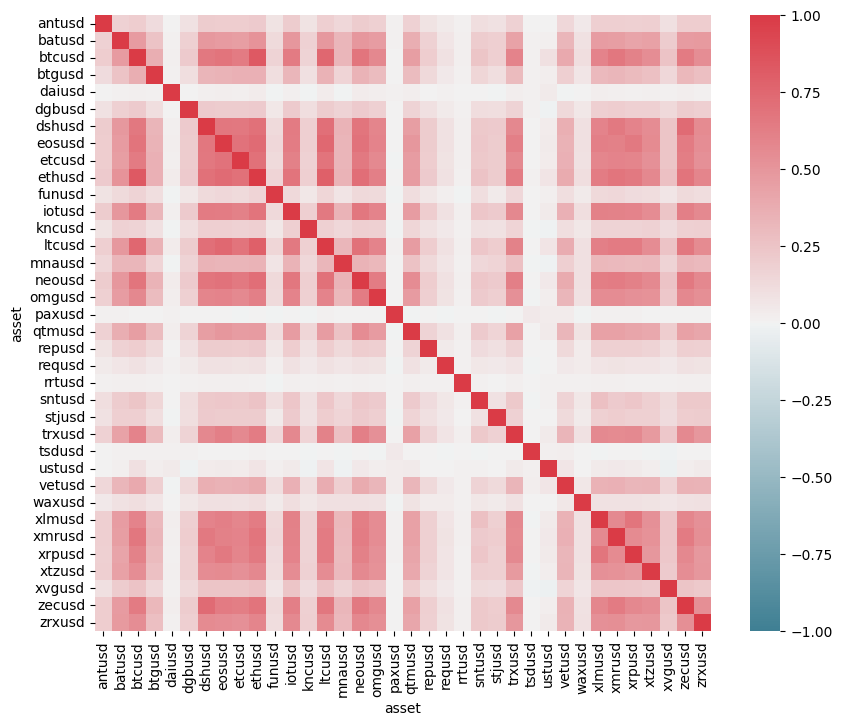

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

close = pd.read_parquet('/home/ckuang/crypto/1hour_data/close.parquet').shift(1)
price_return = close.pct_change(periods = 1)

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(price_return.corr(),
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)


It seems that they are highly correlated. Let's construct our signal using the co-movement idea. First of all, we define 3 status: price increase, price decrease, price unchange as 1,-1,0. Each 1 hour interval, the asset will fall into one of the three status. Compute the ratio when one asset has the same status as the other within a certain time interval and call this symmetric matrix Co-movement matrix. We could also view the entry i,j as the probability that the "information" of j flows to i. Techinically, if there is no decay on information, we should take the infinite power of this matrix, which represent the stable distribution. However, the price change or non-zero return is caused by some actual trading activities and thus we would probably see information decay of this comovement matrix when we take the power. Let's experience below.

After obtaining the matrix, compute the dot product of price return and the matrix, the result is the signal value. Basically, this signal assumes that each asset i will be affected by the trading activities (price movement) of each of the other asset j with some degree depending on their relationship.

In [22]:
# In order to do more complex computation, I re-design the structure of the signal genearation function

import warnings

# get the data at the stand point of current_time
# delay has to be >= 1 to prevent forward looking bias
def get_data(field, nums, current_time, delay = 1):
    data = pd.read_parquet('1hour_data/{}.parquet'.format(field)).loc[:current_time].iloc[:-delay]
    data = data.tail(nums)
    return data


# given a timestamp, return the corresponding signal value
def get_alpha_given_timestamp(current_time, hyperparameter):
    lookback_period = hyperparameter['lookback_period']
    power = hyperparameter['power']

    close = get_data('close', lookback_period, current_time)
    price_return = close.pct_change(1).fillna(0)

    # compute the status matrix
    status = price_return.mask(price_return>0, 1).mask(price_return<0,-1)


    comovement = pd.DataFrame(columns = status.columns, index = status.columns)
    # for each of the asset, compute the number of times of comovement
    for idx in range(status.shape[1]):
        num_same_status = (status == status.iloc[:,idx].values[:,None])
        comovement.iloc[idx] = num_same_status.sum(axis = 0)

    # set the diagonal to be zero
    np.fill_diagonal(comovement.values, 0)
    comovement = comovement.astype(float)
    
    # divide the sum to get the comovement ratio
    comovement = (comovement/comovement.sum(axis=0)).fillna(0)

    # computer the power of covement matrix
    for i in range(power):
        comovement = comovement@comovement
    
    v = EMA(price_return,axis = 0)
    alpha =  (v @ comovement).values.astype(float)

    return alpha
    


In [73]:
from joblib import Parallel, delayed

# get the alpha values using multiprocessing
def get_alpha(start_time, end_time, hyperparameters, n_jobs=100):
    close = pd.read_parquet('1hour_data/close.parquet')
    universe = close.columns
    total_timestamp = close.index

    # get all the valid timestamp 
    trading_timestamp = total_timestamp[(total_timestamp >= pd.Timestamp(start_time)) 
                                        & (total_timestamp < pd.Timestamp(end_time))]

    alpha_values = Parallel(n_jobs=100)(delayed(get_alpha_given_timestamp)(current_time, hyperparameters) 
                    for current_time in trading_timestamp)

    alpha = pd.DataFrame(data = np.vstack(alpha_values), index = trading_timestamp, columns = universe)
    return alpha


start_time, end_time = '20190101','20230601'    
hyperparameters = {'lookback_period': 24*2, 'power': 1}

signal = get_alpha(start_time, end_time, hyperparameters)

In [74]:
print(hyperparameters)
S = -signal.copy().rolling(12).mean()

Backtest1.backtest(signal=(S),type="LONG/SHORT")
display(Backtest1.performance)

S.to_parquet('./signal/comovement1.parquet')

{'lookback_period': 48, 'power': 1}


,Sharpe,Return,WinRate,Annual Turnover,Daily Turnover
2019,3.269671,1.552540,0.509132,788.706736,2.160840
2020,3.901495,1.929026,0.506831,897.660500,2.452624
2021,3.586635,2.292879,0.508333,980.301107,2.685756
2022,1.201562,0.561633,0.501545,791.892424,2.175280
total,3.026117,1.584927,0.506464,864.615517,2.368810


In [75]:
start_time, end_time = '20190101','20230601'    
hyperparameters = {'lookback_period': 24*2, 'power': 2}

signal = get_alpha(start_time, end_time, hyperparameters)

In [76]:
print(hyperparameters)
S = -signal.copy().rolling(12).mean()

Backtest1.backtest(signal=(S),type="LONG/SHORT")
display(Backtest1.performance)

S.to_parquet('./signal/comovement2.parquet')

{'lookback_period': 48, 'power': 2}


,Sharpe,Return,WinRate,Annual Turnover,Daily Turnover
2019,1.743524,0.782887,0.504795,716.928415,1.964187
2020,3.093961,1.468689,0.506717,817.657772,2.234038
2021,3.088298,1.891137,0.506050,925.814650,2.536478
2022,0.674939,0.306558,0.504178,714.033293,1.961405
total,2.216924,1.113091,0.505436,793.585884,2.174208


In [77]:
start_time, end_time = '20190101','20230601'     
hyperparameters = {'lookback_period': 24*2, 'power': 5}

signal = get_alpha(start_time, end_time, hyperparameters)

In [78]:
print(hyperparameters)
S = -signal.copy().rolling(12).mean()

Backtest1.backtest(signal=(S),type="LONG/SHORT")
display(Backtest1.performance)

S.to_parquet('./signal/comovement3.parquet')

{'lookback_period': 48, 'power': 5}


,Sharpe,Return,WinRate,Annual Turnover,Daily Turnover
2019,2.480022,1.109783,0.506621,743.777602,2.037747
2020,2.805340,1.326719,0.503757,868.098124,2.371853
2021,-4.988073,-2.939382,0.446347,4410.864409,12.084560
2022,-2.017274,-0.890910,0.489871,1335.688863,3.669055
total,-0.705424,-0.346944,0.486658,1839.554751,5.039876


As seen above, as we increase the power of co-movement matrix, the performance of signal reduces which aligns with the guessing.
It is also interesting to see that the performance is quite stable among different years compared to previous signals. However, there are limition here because we only have a subset of the whole universe of crypto currencies. We could not measure the information flows from other assets that are not in our universe. If we could fix the data problem and increase our universe, the performance might be different. 

### Outsample Performance

I manually pick 7 signals and combine them together using the equal weight average to roughly test their performance in the outsample period from 20230101 to 20230531

In [81]:
close = pd.read_parquet('1hour_data/close.parquet')
universe = close.columns
total_timestamp = close.index

signal_path = './signal/'
signal_list = ['reversion7','reversion9','reversion10','CloseHighLow','RSI','MACD','comovement1']
combined_signal =  pd.DataFrame(data =0, index = total_timestamp, columns = universe)

for signal_name in signal_list[-1:]:
    signal = pd.read_parquet(signal_path+signal_name+'.parquet')
    #
    signal = cs_Zscore(winsorize(signal))
    combined_signal = combined_signal + signal

combined_signal /= len(signal_list)
    

In [86]:
print('Insample Performance for combined signal')
Backtest1.backtest(signal=combined_signal,type="LONG/SHORT")
display(Backtest1.performance)

print('outsample Performance for combined signal')
Backtest1.backtest(signal=combined_signal, start_date='20230101', end_date='20230601',type="LONG/SHORT")
display(Backtest1.performance)


Insample Performance for combined signal


,Sharpe,Return,WinRate,Annual Turnover,Daily Turnover
2019,3.211441,1.514846,0.508790,819.731979,2.245841
2020,3.806258,1.879693,0.505692,931.435251,2.544905
2021,3.555886,2.262713,0.508105,1014.322984,2.778967
2022,1.098233,0.512634,0.501660,836.952147,2.299056
total,2.957461,1.543379,0.506064,900.584889,2.467356


outsample Performance for combined signal


,Sharpe,Return,WinRate,Annual Turnover,Daily Turnover
2023,4.015389,1.375551,0.507586,410.116811,2.715256
total,4.015389,1.375551,0.507586,991.068486,2.715256


# Summary
***

### **Data Pipeline**
##### Problems and Limitation
   * There seems to be some errors in the data as shown in the data pipeline section. Although I set the criteria of maximum percentage change of price to be 1 between two datapoint (otherwise could be considered as error), errors might still exist in the dataset as it is hard to tell whether the abnormal change is indeed caused by an error or by the true price shock of the crypto currency without further information. Moreover, since the crypto currency is quite volatile, it is possible to see a volume shock and thus hard to distinguish a true error from the data.

   * The author of the dataset claims that there are 400+ crypto pairs, but we could not use the data of the same crypto but with different base currency, for example btc/usd and btc/ust at the same time in our strategy as they are almost linearly dependent. In this case, I choose USD as the base currency. However, the naming of the csv files seems to be problemetic. For example, there are aave-usd.csv, aave_usd.csv and aaveusd.csv. It seems that the data for the same currency was splitted into different csv file for some reasons. Since I don't want to spend too much time on the data part, I only select those currencies with relatively good quality data.
   


### **Backtest framework**
##### Assumption and Limitation
   * The backtest framework assumes that we are able to either long or short at the close. More specifically, we obtain our signal at time T, utilizing the data before and including time T and assumes we could long or short right away at $P_T$ and realize the return of $P_{T+1}/P_{T} - 1$. There are serveral problems in this setting. For example, we can't generate our signal utlizing the current price while trade this signal simultaneously at the current price. There has to be some delay before we obtain our final trading signal. Even if the price change is subtle during the period of signal generation, we still need to consider the price impact/ liquidity as the price might move in a unfavorable direction depending on our trading volume/capacity. A more reasonable approach to address the above problems is to assume we could enter the position at the VWAP between T and T+1 and thus realize the return of VWAP to CLOSE for new position and return of CLOSE to CLOSE for existing position. However, since the quality of data is questionable especially for the "volume" entry, I didn't choose to compute the VWAP as that might cause unexpected bias.

   * The error in price data might also have a significant impact on the backtesting framework and cause bias to the backtest result. For exmaple, we see a price jump for RRT/USD in Feb 2019. Signals that have a large weight/exposure on RRT/USD in that timestamp might have relatively high performance, but this is not due to its "predictive power" per se. Moreover, the universe size is small (36 crypto), so the strategy or the backtesting result might be quite sensible to the error.

   * The backtesting result is not statistically significant enough to show the predicting power of the signal because of the size of universe and it is hard to check the monotonicity.


### **Signal**

##### Ideas
   1. Mean Reversion

   2. Technical Indicator

   3. Price Co-movement

   4. Other possible ideas
      * Lead-Lag: Since the crypto currency is highly correlated, it is possible that one leads the movement of another. Analyze if there's time lags between the movement of two correlated cryptos.

      * Centrality Measures: Find the most influential currencies by applying centrality measures on their relationship matrix like Co-movement, Co-trading, Co-volatilty, Co-jump, Co-ourrence, etc. Those influential currencies might lead the market movement. Or more influential currencies might outperform the less influential ones.

      * Community Detection: Using modularity based method to find communities/clusters/groups. Currencies inside the same group might behave similarly while differently compared to those in other group. We could design signals to long certain group and short certain group depending on their relationship. Or we could consider each group as independent with its own dynamics. Thus we could apply different strategy to different groups. Or even use the information to filter out our universe.

      * Volume Analysis: Since the crypto is avaiable to trade 24/7. The trading activity might be different within different time interval in a day. For example, investor from different time zone might trade at different time or retail investor might only trade during daytime while retail investor especially those with systematic strategy are able to trade continuously. Thus, analyzing the trading activity in different time interval might exposure some useful information to generate alpha signals.


      * Other Data: We could also integrate other data sources like fundamental data or alternative data to create signals. But it is out of the scope of this project.



